# Unsupervised Clustering of Venus Atmosphere UV Pictures  

In this project we study the dataset of the UV pictures of Venus' Atmosphere taken by the Japanese Akatsuki satellite. The dataset is available here: https://darts.isas.jaxa.jp/planet/project/akatsuki/uvi.html.en

After having properly pre-processed the data and having produced a suitable dataset, we apply techniques of unsupervised machine learning in order to cluster the pictures of the the atmosphere depending on the features. 

We already point out that the dataset used has pictures that are too far away from the planet to be able to discover interesting features. Nonetheless, the method developed can be equally applied to other datasets and is for this reason interesting and worth sharing. 

In the present file we show all the different steps. The main loop that has then been run to analyse the whole dataset can be seen in main.py.

A more detailed report of all the steps and techniques used can be found here: https://www.overleaf.com/read/rymmcwknjmtv

### Table of Contents

* [1 Data Preprocessing](#chapter1)
    * [1.1 Load and visualize dataset](#section_1_1)
    * [1.2 Clear the pictures](#section_1_2)
    * [1.3 Normalise the picture intensity](#section_1_3)
    * [1.4 Create a map projection](#section_1_4)
    * [1.5 Cut the squares from the project picture](#section_1_5)
* [2 Unsupervised Clustering](#chapter2)

## 1. Data Preprocessing <a class="anchor" id="chapter1"></a>

### 1.1 Load and visualize dataset <a class="anchor" id="section_1_1"></a>

In [1]:
# imports

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os


import matplotlib.dates
import datetime

from utils import *

import time

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates

from datetime import datetime

In [2]:
# width of the future squares to crop
WIDTH = 100

#---------------------- Load Data ---------------------
rootdir2 = '/Users/alessandro/Desktop/Venus/data_test/pics'
uv_imgs = load_data(rootdir2)

rootdir1 = '/Users/alessandro/Desktop/Venus/data_test/geo'
geo_imgs = load_data(rootdir1)

matched_files = match_uv_to_geo(geo_imgs, uv_imgs)
print('Matches: ', len(matched_files))

subdir:  /Users/alessandro/Desktop/Venus/data_test/pics
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0084
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0085
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0086
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0087
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0088
subdir:  /Users/alessandro/Desktop/Venus/data_test/pics/r0089
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0084
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0085
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0086
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0087
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0088
subdir:  /Users/alessandro/Desktop/Venus/data_test/geo/r0089
Matches:  595


Text(0, 0.5, 'Distance (km)')

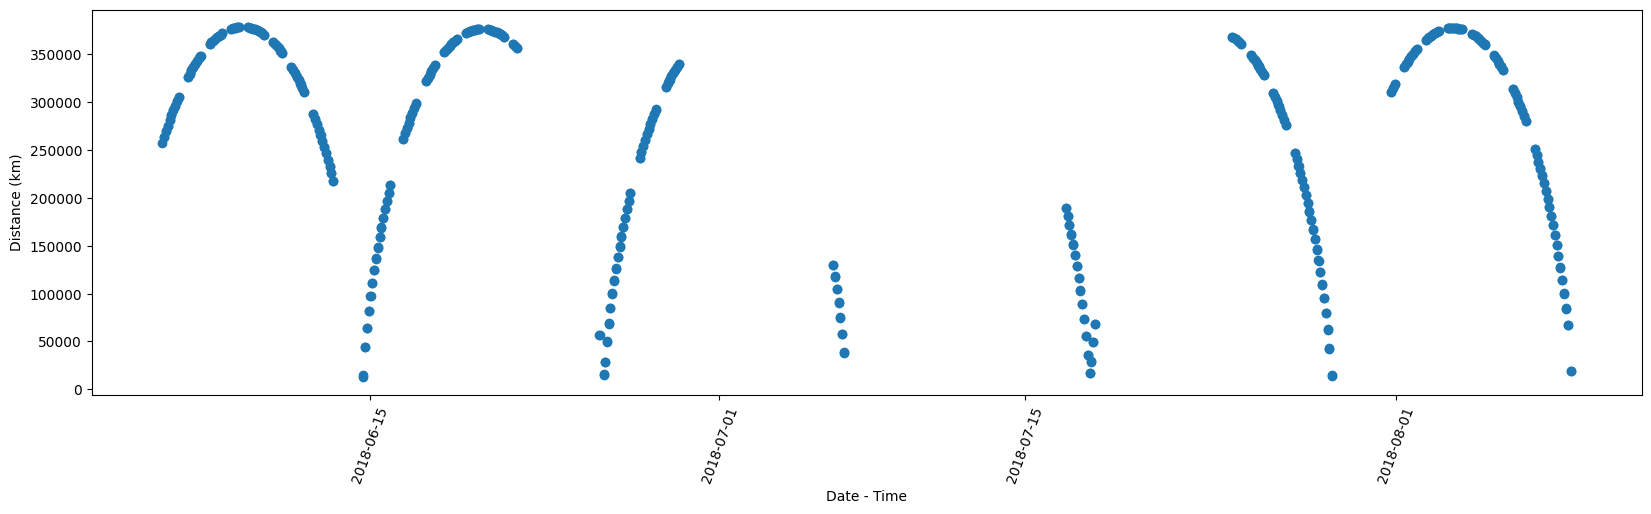

In [5]:
#--------------------- Plot Distances vs Time --------------------
x_values = []
y_values = []
    
for match in matched_files:
    uv_pic = match[1]
    
    # extract the date information
    year = int(uv_pic.info['date'][0:4])
    month = int(uv_pic.info['date'][4:6])
    day = int(uv_pic.info['date'][6:8]) 
    
    # extract the time information
    hour = int(uv_pic.info['time'][0:2])
    minute = int(uv_pic.info['time'][2:4])
    second = int(uv_pic.info['time'][4:6])
            
    # add the values to the x and y 
    x_values.append(datetime(year, month, day, hour, minute))
    y_values.append(uv_pic.info['distance'])    

# create the matplotlib figure
dates = matplotlib.dates.date2num(x_values) 
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)

# plot the dates
matplotlib.pyplot.plot_date(dates, y_values)

# set the labels
plt.xlabel('Date - Time')
plt.ylabel('Distance (km)')

In [10]:
#----------------------- Extract distance ranges ------------------
new_matches = []

for i, match in enumerate(matched_files):
    # select the pics that are close enough to the planet
    if match[0].info['distance'] < 200000 :
        new_matches.append(match)
        
# total number of pics
total_n_pics = len(new_matches)

print(total_n_pics)

162


### 1.2 Clear the pictures <a class="anchor" id="section_1_2"></a>

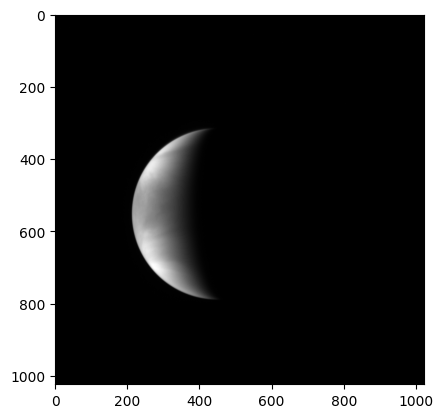

In [17]:
k = 150

# ---------------------- Plot pic --------------------
match = new_matches[k]
geo_pic = match[0]
uv_pic = match[1]

plt.imshow(uv_pic.to_array(), cmap='gray', vmin=0)

In [18]:
# ----------------- Cut Off of the image ----------------
# extract the latitudes
lats_geo = geo_pic.to_array(1)
# extract the longitudes
lons_geo = geo_pic.to_array(2)
# make a copy 
data_geo = np.copy(uv_pic.to_array())
# extract the angles
angles = geo_pic.to_array(5)

# convert to radiants 
angles = geo_pic.to_array(5)*np.pi/180
    
# Remove what the geo file doesn't see
indices = np.isnan(angles)
angles[indices] = np.pi

# Remove the part of the planet in the dark
cos_values = np.cos(angles)
indices = np.where(cos_values <= 0.15)
data_geo[indices]=np.nan

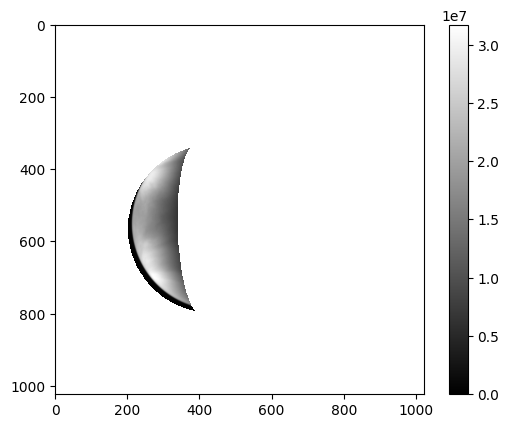

In [19]:
# ---------------------- Visualise current results --------------------
plt.imshow(data_geo, cmap='gray', vmin=0)
plt.colorbar()

### 1.3 Normalise the picture intensity <a class="anchor" id="section_1_3"></a>

We now want to normalise the pixel intensity, considering that, due to the angle connecting the point on the surface to the sun, its exposition to the light will be different. In other words, some pixels are more in the shade than others. To correct this and normalise them, we first plot the pixel intensity vs the cosine of the angle. Then we fit the values and normalise wrt. to the fitted line.

In [23]:
# ----------------- Correct the pixel intensity ----------------
from pylab import * 

# reshape the value so that its easier to plot 
reshaped_cos_values = np.reshape(cos_values, (1,-1))[0]
reshaped_data_geo = np.reshape(data_geo, (1,-1))[0]

# select only the indices that are not 
index_cos = ~np.isnan(reshaped_cos_values)
index_data = ~np.isnan(reshaped_data_geo)
index = np.logical_and(index_cos, index_data)

# select only the meainingful values
x = reshaped_cos_values[index]
y = reshaped_data_geo[index]

if len(x)>0 and len(y)>0:
    # fit the data
    a,b = polyfit(x, y, 1) 

    # normalise the data
    y = y/(a*x+b)

In [21]:
#----------------- Adjust the original data ---------------
new_data_geo = np.copy(data_geo)
new_data_geo = new_data_geo/(a*cos_values + b)  

indices_black= np.where(new_data_geo <= 0.1*np.nanmax(new_data_geo))
new_data_geo[indices_black] = np.nan

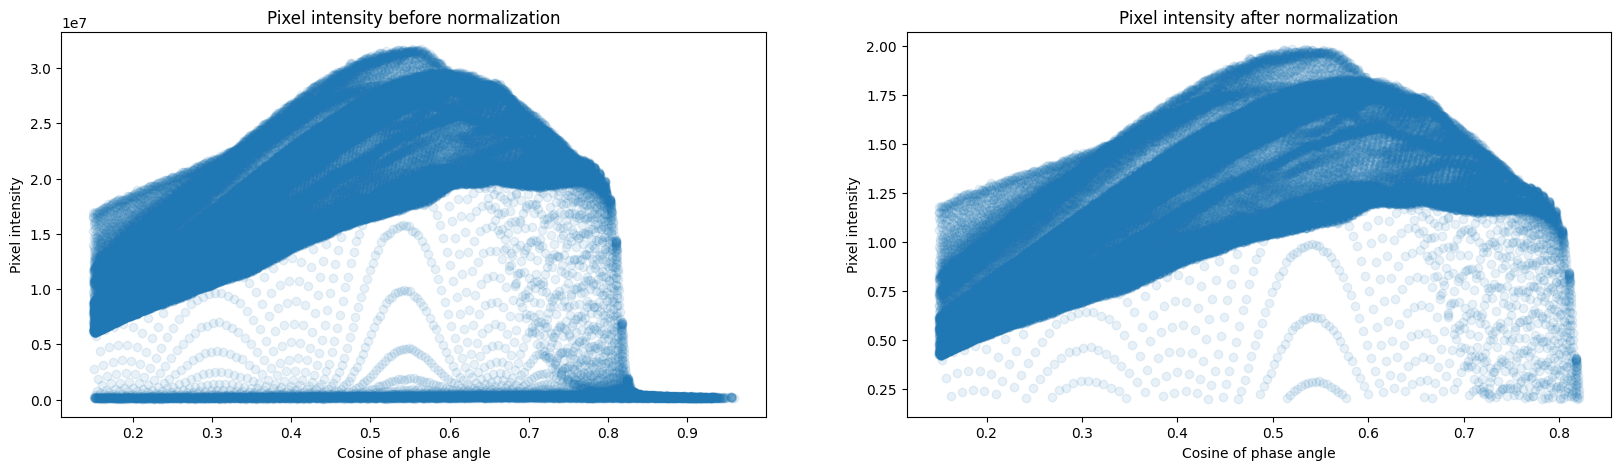

In [22]:
# ---------------- Plot the finals results ----------------- 
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(cos_values, data_geo, alpha=0.1)
ax2.scatter(cos_values, new_data_geo, alpha=0.1)
fig.set_figheight(5)
fig.set_figwidth(20)
ax1.set(xlabel="Cosine of phase angle", ylabel="Pixel intensity")
ax1.title.set_text('Pixel intensity before normalization')

ax2.set(xlabel="Cosine of phase angle", ylabel="Pixel intensity")
ax2.title.set_text('Pixel intensity after normalization')

plt.show()

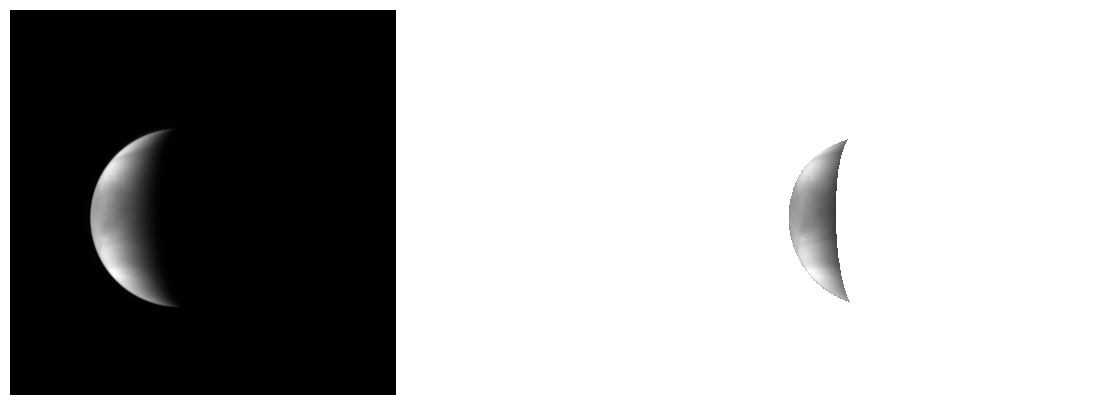

In [24]:
# ----------------- PLot current result ---------------
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.imshow(uv_pic.to_array(), cmap='gray', vmin=0)
ax2.imshow(new_data_geo, cmap='gray', vmin=0)

ax1.axis('off')
ax2.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

### 1.4 Create a map projection <a class="anchor" id="section_1_4"></a>

We now use the package Basemap to project the UV picture according to a selected projection. We use the Cylindrical equal-area projection (cea) since this has the property that two any regions of the map can be compared area-wise.  

82.37721 -72.6931 350.6683 254.9158


(0.0, 10647187.471415792, 0.0, 12397245.601093808)

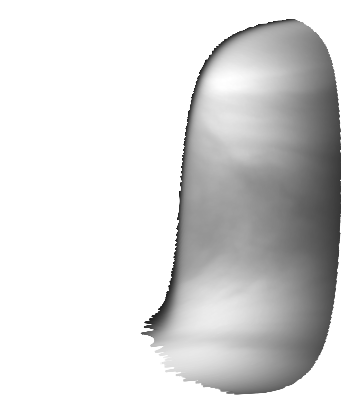

In [33]:
# ----------------- Creat map on basemap ---------------
fig = plt.figure(figsize=(5,5))

# extract some useful information
a = np.isnan(data_geo)
lats_geo[a] = np.nan
lons_geo[a] = np.nan

maxlat = np.nanmax(lats_geo)
minlat = np.nanmin(lats_geo)
maxlong = np.nanmax(lons_geo)
minlong = np.nanmin(lons_geo)

print(maxlat, minlat, maxlong, minlong)

# create the map with basemap 
m=Basemap(projection='cea', 
            llcrnrlat=minlat,
            urcrnrlat=maxlat,
            llcrnrlon=minlong,
            urcrnrlon=maxlong,
            resolution = 'c',)

# recenter the longitudes, if needed 
i1 = np.where((geo_pic.to_array(2) <= 1) & (geo_pic.to_array(1) <= 80) & (geo_pic.to_array(1) >= -80))
i2 = np.where((geo_pic.to_array(2) >= 359) & (geo_pic.to_array(1) <= 80) & (geo_pic.to_array(1) >= -80))

if len(i1[0])>0 and len(i2[0])>0:
    lons_geo = lons_geo + 180
    ind = np.where( lons_geo >= 360.0 )
    lons_geo[ind] = lons_geo[ind] - 360

# project the lats and lons with the necessary projection
lons, lats = m(lons_geo, lats_geo)

# plot the map
m.contour(lons, lats, new_data_geo, 1000, cmap='gray', vmin=0)

# remove the axis
ax = fig.gca()
ax.axis('off')

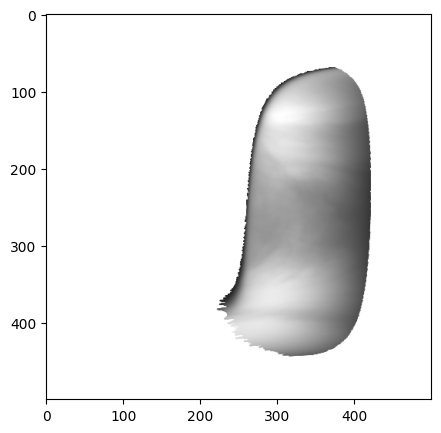

In [35]:
# ----------------------- Save projection of the pic as array pic ----------------------
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

canvas = FigureCanvas(fig)

canvas.draw()       # draw the canvas, cache the renderer

image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

fig1, ax1 = plt.subplots(1, 1, figsize=(5,5))
plt.imshow(image_from_plot)

### 1.5 Cut the squares from the project picture <a class="anchor" id="section_1_5"></a>

In [36]:
# ----------------- Find squares ---------------
binary_matrix = np.copy(image_from_plot[:, :, 0])

print(binary_matrix.shape)

indices_1 = np.where(binary_matrix >= 255)

binary_matrix[indices_1] = 1

coords = []


while find_square(binary_matrix, m, degrees=100) != None:
    # extract coords
    r0, c0, r1, c1 = find_square(binary_matrix, m, degrees=100)
    print(r0, c0, r1, c1)
    # remove current square
    binary_matrix = remove_square(binary_matrix, r0, c0, r1, c1)
    # show image so far
    #plt.imshow(binary_matrix, cmap='gray')
    # save coords
    coords.append([r0, c0, r1, c1])

(500, 500)
105 312 204 411
204 264 303 363
303 255 402 354


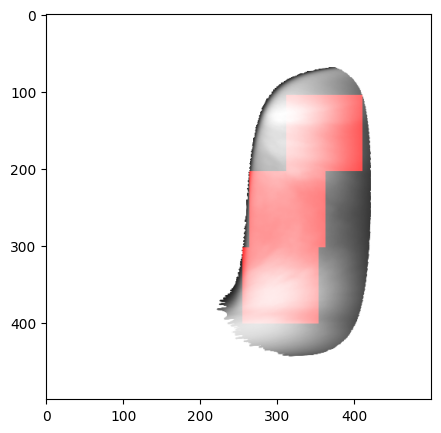

In [38]:
# ----------------- Mark the area ---------------
marked_pic = np.copy(image_from_plot)
for x in coords:
    r0, c0, r1, c1 = x
    marked_pic[r0:r1, c0:c1, 0] = 255
    
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.imshow(marked_pic)

3


IndexError: list index out of range

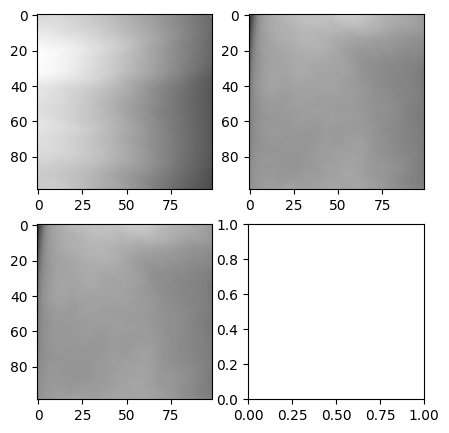

In [40]:
# ---------------- Cut the pics --------------
squares = []

for x in coords:
    r0, c0, r1, c1 = x
    square = image_from_plot[r0:r1, c0:c1, :]
    squares.append(square)
    
print(len(squares))


n_r = 2
n_c = int(len(squares)/n_r+1)
f, axarr = plt.subplots(n_r,n_c, figsize=(5,5))


# plt.imshow(squares[(r+1)*(c+1) - 1])

for r in range(n_r):
    for c in range(n_c):
        axarr[r,c].imshow(squares[(r+1)*(c+1) - 1])
plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.4)
plt.imshow(square)

## 2. Unsupervised Clustering <a class="anchor" id="chapter2"></a>

Several techniques have been applied to try to classify with unsupervised clustering the pictures cut in this way. The results and the models used can be seen in the report linked in the introduction.